# Traffic Forecasting using Graph Neural Networks

In [ ]:
#install pytorch geometric
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cpu.html
!pip install torch-geometric

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from google.colab import drive
import scipy.sparse as sp
import torch
import torch.utils.data
from torch_geometric.utils import from_networkx
import networkx as nx
import math
import random

from sklearn import preprocessing
drive.mount('/content/drive')

Get dataset files (upload correspondent *adj.npz* file into colab content folder)

In [ ]:
#METR-LA dataset
#!cp /content/drive/MyDrive/metr-la.csv /content/dataset.csv

#Pems-bay dataset
#!cp /content/drive/MyDrive/pems-bay.csv /content/dataset.csv

#Pemsd7-m dataset
!cp /content/drive/MyDrive/pemsd7-m.csv /content/dataset.csv

In [ ]:
#dataset path
dataset_path = '/content/dataset.csv'
npz_path = '/content/adj.npz'

Read dataset and convert values into numpy array

In [ ]:
# read the CSV file
df = pd.read_csv(dataset_path)

dataset = df.values
dataset.astype(np.float128)

array([[68.1, 66.8, 61.7, ..., 67.7, 68.8, 68.8],
       [68. , 64.3, 66.6, ..., 70.2, 69.1, 68.7],
       [68.3, 67.8, 65.9, ..., 70.4, 67.3, 69. ],
       ...,
       [68.9, 37.9, 68.8, ..., 68.7, 67.5, 19.7],
       [69.2, 37.8, 68.7, ..., 67.7, 67.4, 19.5],
       [68.6, 52.9, 68.6, ..., 68.1, 68.5, 19.1]], dtype=float128)

Get data from *adj.npz* file

In [ ]:
# convert adj to Compressed Sparse Column format
adj = sp.load_npz(npz_path)
n = adj.shape[0]
adj = adj.tocsc()
adj = adj.todense()

### Create correspondent graph using networkx package

In [ ]:
#create graph
G = nx.Graph()

for i in range(adj.shape[0]):
  for j in range(adj.shape[0]):
    if adj[i, j] != 1 and adj[i, j] != 0 and not G.has_edge(j, i):
      G.add_edge(i, j, length=adj[i, j])

In [ ]:
#set sensor number and measurements values attributes to all nodes
nx.set_node_attributes(G, 0, 'x')
nx.set_node_attributes(G, 0, 'y')

rate = 0.8
x_size = int(dataset.shape[0] * rate)

for i in range(dataset.shape[1]):
  #standard approach
  G.nodes[i]['x'] = dataset[:x_size, i]
  G.nodes[i]['y'] = dataset[x_size:, i]

In [ ]:
#convert into torch geometric data
data = from_networkx(G)
print(type(data))

print(data)
print(data.x)
print(data.edge_index)

<class 'torch_geometric.data.data.Data'>
Data(x=[228, 10136], edge_index=[2, 18856], y=[228, 2535], length=[18856])
tensor([[68.1000, 68.0000, 68.3000,  ..., 68.9000, 70.4000, 71.4000],
        [66.8000, 64.3000, 67.8000,  ..., 65.8000, 70.6000, 66.0000],
        [61.7000, 66.6000, 65.9000,  ..., 70.8000, 71.6000, 71.7000],
        ...,
        [67.7000, 67.8000, 67.1000,  ..., 68.0000, 66.8000, 65.5000],
        [70.8000, 68.1000, 71.3000,  ..., 66.3000, 64.0000, 65.9000],
        [67.1000, 66.7000, 67.2000,  ..., 66.2000, 65.8000, 65.1000]],
       dtype=torch.float64)
tensor([[  0,   0,   0,  ..., 227, 227, 227],
        [  1,   2,   3,  ..., 224, 225, 226]])


In [ ]:
# Split the data 
train_ratio = 0.2
num_nodes = data.x.shape[0]
num_train = int(num_nodes * train_ratio)
idx = [i for i in range(num_nodes)]

np.random.shuffle(idx)
train_mask = torch.full_like(data.y, False, dtype=bool)
train_mask[idx[:num_train]] = True
test_mask = torch.full_like(data.y, False, dtype=bool)
test_mask[idx[num_train:]] = True

### GCN Model

In [ ]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(123)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.lin1 = torch.nn.Linear(hidden_channels, hidden_channels*2)
        self.lin2 = torch.nn.Linear(hidden_channels*2, data.y.shape[1])

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.lin2(x)
        return x

In [ ]:
model = GCN(hidden_channels=500)
print(model)
model = model.double()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = torch.nn.MSELoss()
criterion2 = torch.nn.L1Loss()

GCN(
  (conv1): GCNConv(10136, 500)
  (lin1): Linear(in_features=500, out_features=1000, bias=True)
  (lin2): Linear(in_features=1000, out_features=2535, bias=True)
)


Define train and test functions

In [ ]:
def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x.double(), data.edge_index)
      loss = criterion(out[train_mask], data.y[train_mask])
      lossMAE = criterion2(out[train_mask], data.y[train_mask])
      loss.backward()
      optimizer.step()
      loss = torch.sqrt(loss)
      return loss, lossMAE

def test():
      model.eval()
      out = model(data.x.double(), data.edge_index)
      test_error = out[test_mask] - data.y[test_mask]
      mse_error = test_error**2
      mae_error = abs(test_error)
      rmse = torch.sqrt(torch.mean((out[test_mask]-data.y[test_mask])**2))
      test_mse = int(mse_error.sum()) / int(test_mask.sum())
      test_mae = int(mae_error.sum()) / int(test_mask.sum())
      return rmse, test_mae, out

Train and test the model

In [ ]:
train_loss = {'RMSE': [], 'MAE': []}

for epoch in range(1, 300):
    loss, lossMAE = train()
    train_loss['RMSE'].append(loss)
    train_loss['MAE'].append(lossMAE)
    print(f'Epoch: {epoch:03d}, RMSE Loss: {loss:.4f}, MAE Loss: {lossMAE:.4f}')

In [ ]:
#test
test_mse, test_mae, out = test()
print(f'\nTest RMSE: {test_mse:.4f}')
print(f'Test MAE: {test_mae:.4f}')


Test RMSE: 12.9302
Test MAE: 9.9424


Plot train loss

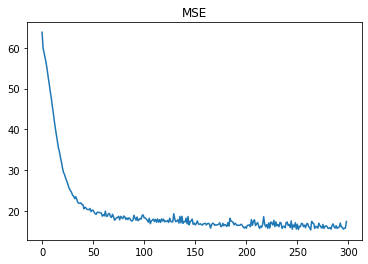

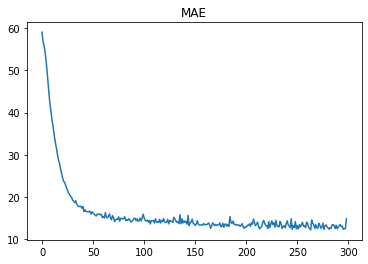

In [ ]:
#plot train losses
mse_loss = [float(x) for x in train_loss['RMSE']]
mae_loss = [float(x) for x in train_loss['MAE']]

plt.plot(range(len(mse_loss)), mse_loss, label='MSE')
plt.title('MSE')
plt.show()

plt.plot(range(len(mae_loss)), mae_loss, label='MAE')
plt.title('MAE')
plt.show()

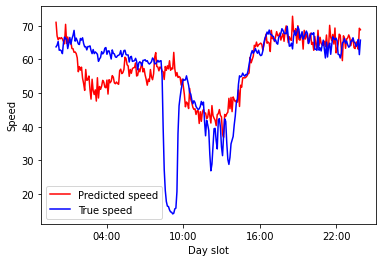

In [ ]:
day_size = 288
day = np.arange(day_size).tolist()

sensor_id = 163

predictions = out[sensor_id, :day_size].detach().numpy()
true_val = data.y[sensor_id, :day_size].tolist()

l1, = plt.plot(day, predictions, color='red')
l2, = plt.plot(day, true_val, color='blue')

plt.legend((l1, l2), ['Predicted speed', 'True speed'])

plt.xlabel('Day slot')
plt.ylabel('Speed')
plt.xticks(np.arange(min(day) + 4*12, max(day) + 2, 6*12), labels=('04:00', '10:00', '16:00', '22:00'))

plt.show()